# 模型对抗攻击

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/tutorials/application/zh_cn/cv/mindspore_fgsm.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/tutorials/application/zh_cn/cv/mindspore_fgsm.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/master/tutorials/application/source_zh_cn/cv/fgsm.ipynb)

近年来随着数据、计算能力、理论的不断发展演进，深度学习在图像、文本、语音、自动驾驶等众多领域都得到了广泛应用。与此同时，人们也越来越关注各类模型在使用过程中的安全问题，因为AI模型很容易受到外界有意无意的攻击而产生错误的结果。

在本案例中，我们将以梯度符号攻击（Fast Gradient Sign Method，FGSM）为例，演示此类攻击是如何误导模型的。

## 对抗样本定义

Szegedy在2013年最早提出对抗样本的概念：

在原始样本处加入人类无法察觉的微小扰动，使得深度模型性能下降，这种样本即对抗样本。如下图所示，本来预测为“panda”的图像在添加噪声之后，模型就将其预测为“gibbon”，右边的样本就是一个对抗样本：

![fgsm-panda-image](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/application/source_zh_cn/cv/images/panda.png)

> 图片来自[Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572)。

## 攻击方法

对模型的攻击方法在宏观层面可以从如下两个方面进行分类：

1. 攻击者掌握的信息多少：

   - **白盒攻击**：攻击者具有对模型的全部知识和访问权限，包括模型结构、权重、输入、输出，在产生对抗性攻击数据的过程中能够与模型系统有所交互。由于模型的信息完全被攻击者掌握，攻击者可以针对被攻击模型的特性设计特定的攻击算法。

   - **黑盒攻击**：与白盒攻击相反，攻击者仅具有关于模型的有限知识。攻击者对模型的结构权重一无所知，仅了解部分输入输出。

2. 攻击者的目的：

   - **有目标的攻击**：攻击者将模型结果误导为特定分类。

   - **无目标的攻击**：攻击者只想产生错误结果，而不在乎新结果是什么。

本案例中用到的梯度符号攻击FGSM是一种白盒攻击方法，既可以是有目标也可以是无目标攻击。

> 更多的模型安全功能可参考[MindArmour](https://www.mindspore.cn/mindarmour)，现已支持FGSM、LLC、Substitute Attack等多种对抗样本生成方法，并提供对抗样本鲁棒性模块、Fuzz Testing模块、隐私保护与评估模块，帮助用户增强模型安全性。

### 快速梯度符号攻击（FGSM）

分类网络的训练会定义一个损失函数，用于衡量模型输出值与样本真实标签的距离，通过反向传播计算模型梯度，梯度下降更新网络参数，减小损失值，提升模型精度。

FGSM（Fast Gradient Sign Method）是一种简单高效的对抗样本生成方法。不同于正常分类网络的训练过程，FGSM通过计算loss对于输入的梯度为 $\nabla_x J(\theta ,x ,y)$，梯度表征了loss对于输入变化的敏感性。

然后在原始输入加上上述梯度，使得loss增大，导致模型对于改造后的输入样本分类效果变差，从而达到攻击效果。

对抗样本的另一要求是生成样本与原始样本的差异要尽可能的小，使用sign函数可以使得修改图片时尽可能的均匀。

产生的对抗扰动用公式可以表示为：

$$ \eta  = \varepsilon  sign(\nabla_x  J(\theta)) \tag{1}$$

对抗样本可公式化为：

$$ x' = x + \varepsilon sign(\nabla_x J(\theta ,x ,y)) \tag{2}$$

其中，

- $x$：正确分类为“Pandas”的原始输入图像。
- $y$：是$x$的输出。
- $\theta$：模型参数。
- $\varepsilon$：攻击系数。
- $J(\theta, x, y)$：训练网络的损失。
- $\nabla_x  J(\theta)$：反向传播梯度。

## 数据处理

本案例将使用MNIST训练一个精度达标的LeNet网络，然后运行上文中所提到的FGSM攻击方法，达到欺骗网络模型，让模型实现错误分类的效果。

以下示例代码将数据集下载并解压到指定位置。

In [1]:
from mindvision.dataset import Mnist

# 下载并处理MNIST数据集
download_train = Mnist(path="./mnist", split="train", shuffle=True, download=True)
download_eval = Mnist(path="./mnist", split="test", download=True)

dataset_train = download_train.run()
dataset_eval = download_eval.run()

下载的数据集文件的目录结构如下：

```text
./mnist
├── test
│   ├── t10k-images-idx3-ubyte
│   └── t10k-labels-idx1-ubyte
└── train
    ├── train-images-idx3-ubyte
    └── train-labels-idx1-ubyte
```

## 训练LeNet网络

实验中使用LeNet作为演示模型完成图像分类，这里先定义网络并使用MNIST数据集进行训练。

定义LeNet网络：

In [2]:
from mindvision.classification.models import lenet

network = lenet(num_classes=10, pretrained=False)

定义优化器与损失函数：

In [3]:
import mindspore.nn as nn

net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
net_opt = nn.Momentum(network.trainable_params(), learning_rate=0.01, momentum=0.9)

定义网络参数：

In [4]:
from mindspore import ModelCheckpoint, CheckpointConfig

config_ck = CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10)
ckpoint = ModelCheckpoint(prefix="checkpoint_lenet", config=config_ck)

训练LeNet网络：

In [5]:
from mindspore.train import Model
from mindvision.engine.callback import LossMonitor

model = Model(network, loss_fn=net_loss, optimizer=net_opt, metrics={'accuracy'})
model.train(5, dataset_train, callbacks=[ckpoint, LossMonitor(0.01, 1875)])

Epoch:[  0/  5], step:[ 1875/ 1875], loss:[0.094/0.094], time:2345.947 ms, lr:0.01000
Epoch time: 3680.524 ms, per step time: 1.963 ms, avg loss: 0.094
Epoch:[  1/  5], step:[ 1875/ 1875], loss:[0.323/0.323], time:1250.154 ms, lr:0.01000
Epoch time: 1250.843 ms, per step time: 0.667 ms, avg loss: 0.323
Epoch:[  2/  5], step:[ 1875/ 1875], loss:[0.014/0.014], time:1408.945 ms, lr:0.01000
Epoch time: 1409.764 ms, per step time: 0.752 ms, avg loss: 0.014
Epoch:[  3/  5], step:[ 1875/ 1875], loss:[0.198/0.198], time:1332.741 ms, lr:0.01000
Epoch time: 1333.454 ms, per step time: 0.711 ms, avg loss: 0.198
Epoch:[  4/  5], step:[ 1875/ 1875], loss:[0.001/0.001], time:1436.917 ms, lr:0.01000
Epoch time: 1437.587 ms, per step time: 0.767 ms, avg loss: 0.001


测试此时的网络，可以观察到LeNet已经达到比较高的精度：

In [6]:
acc = model.eval(dataset_eval)
print("{}".format(acc))

{'accuracy': 0.9888822115384616}


加载已经训练好的LeNet模型：

In [7]:
from mindspore import load_checkpoint, load_param_into_net

param_dict = load_checkpoint("checkpoint_lenet-5_1875.ckpt")
load_param_into_net(network, param_dict)

### 实现FGSM

在得到精准的LeNet网络之后，下面将会采用FSGM攻击方法，在图像中加载噪声后重新进行测试。

先通过损失函数求取反向梯度：

In [8]:
class WithLossCell(nn.Cell):
    """包装网络与损失函数"""

    def __init__(self, network, loss_fn):
        super(WithLossCell, self).__init__()
        self._network = network
        self._loss_fn = loss_fn

    def construct(self, data, label):
        out = self._network(data)
        return self._loss_fn(out, label)


class GradWrapWithLoss(nn.Cell):
    """通过loss求反向梯度"""

    def __init__(self, network):
        super(GradWrapWithLoss, self).__init__()
        self._grad_all = ops.composite.GradOperation(get_all=True, sens_param=False)
        self._network = network

    def construct(self, inputs, labels):
        gout = self._grad_all(self._network)(inputs, labels)
        return gout[0]

然后根据公式（2）实现FGSM攻击：

In [9]:
import numpy as np
from mindspore import Tensor

class FastGradientSignMethod:
    """实现FGSM攻击"""

    def __init__(self, network, eps=0.07, loss_fn=None):
        # 变量初始化
        self._network = network
        self._eps = eps
        with_loss_cell = WithLossCell(self._network, loss_fn)
        self._grad_all = GradWrapWithLoss(with_loss_cell)
        self._grad_all.set_train()


    def _gradient(self, inputs, labels):
        # 求取梯度
        out_grad = self._grad_all(inputs, labels)
        gradient = out_grad.asnumpy()
        gradient = np.sign(gradient)
        return gradient

    def generate(self, inputs, labels):
        # 实现FGSM
        inputs_tensor = Tensor(inputs)
        labels_tensor = Tensor(labels)
        gradient = self._gradient(inputs_tensor, labels_tensor)
        # 产生扰动
        perturbation = self._eps*gradient
        # 生成受到扰动的图片
        adv_x = inputs + perturbation
        return adv_x

    def batch_generate(self, inputs, labels, batch_size=32):
        # 对数据集进行处理
        arr_x = inputs
        arr_y = labels
        len_x = len(inputs)
        batches = int(len_x / batch_size)
        res = []
        for i in range(batches):
            x_batch = arr_x[i*batch_size: (i + 1)*batch_size]
            y_batch = arr_y[i*batch_size: (i + 1)*batch_size]
            adv_x = self.generate(x_batch, y_batch)
            res.append(adv_x)
        adv_x = np.concatenate(res, axis=0)
        return adv_x

再次处理MINIST数据集中测试集的图片：

In [10]:
images = []
labels = []
test_images = []
test_labels = []
predict_labels = []

ds_test = dataset_eval.create_dict_iterator(output_numpy=True)

for data in ds_test:
    images = data['image'].astype(np.float32)
    labels = data['label']
    test_images.append(images)
    test_labels.append(labels)
    pred_labels = np.argmax(model.predict(Tensor(images)).asnumpy(), axis=1)
    predict_labels.append(pred_labels)

test_images = np.concatenate(test_images)
predict_labels = np.concatenate(predict_labels)
true_labels = np.concatenate(test_labels)

## 运行攻击

由FGSM攻击公式中可以看出，攻击系数$\varepsilon$越大，对梯度的改变就越大。当$\varepsilon$ 为零时则攻击效果不体现。

$$\eta = \varepsilon sign(\nabla_x  J(\theta)) \tag{3}$$

现在先观察当$\varepsilon$为零时的攻击效果：

In [11]:
import mindspore.ops as ops

fgsm = FastGradientSignMethod(network, eps=0.0, loss_fn=net_loss)
advs = fgsm.batch_generate(test_images, true_labels, batch_size=32)

adv_predicts = model.predict(Tensor(advs)).asnumpy()
adv_predicts = np.argmax(adv_predicts, axis=1)
accuracy = np.mean(np.equal(adv_predicts, true_labels))
print(accuracy)

0.9888822115384616


再将$\varepsilon$设定为0.5，尝试运行攻击：

In [12]:
fgsm = FastGradientSignMethod(network, eps=0.5, loss_fn=net_loss)
advs = fgsm.batch_generate(test_images, true_labels, batch_size=32)

adv_predicts = model.predict(Tensor(advs)).asnumpy()
adv_predicts = np.argmax(adv_predicts, axis=1)
accuracy = np.mean(np.equal(adv_predicts, true_labels))
print(accuracy)

0.36828926282051283


从上面的打印结果可以看出，此时LeNet模型的精度大幅降低。

下面演示受攻击照片现在的实际形态，可以看出图片只是发生了很小的变化，然而在精度测试中却严重下降：

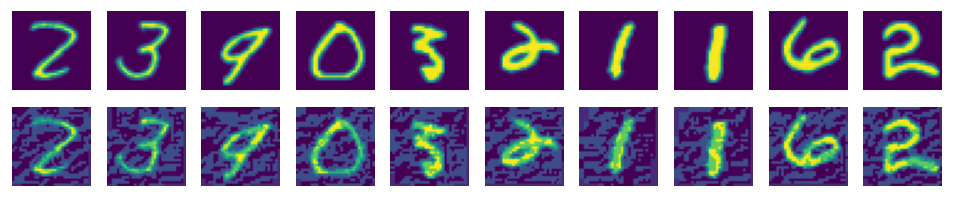

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

adv_examples = np.transpose(advs[:10], [0, 2, 3, 1])
ori_examples = np.transpose(test_images[:10], [0, 2, 3, 1])

plt.figure(figsize=(10, 3), dpi=120)
for i in range(10):
    plt.subplot(3, 10, i+1)
    plt.axis("off")
    plt.imshow(np.squeeze(ori_examples[i]))
    plt.subplot(3, 10, i+11)
    plt.axis("off")
    plt.imshow(np.squeeze(adv_examples[i]))
plt.show()